In [1]:
# Библиотеки (пакеты)
import os                       # Системные функции (работа с директориями, файлами и т.п.)
import shutil                   # unix-подобные команды
import patoolib                 # Работа с архивами (7z, rar)
import numpy as np              # Работа с массивами (матрицами)
import matplotlib.pyplot as plt # Визуализация
import cv2                      # OpenCV - обработка изображений
import cartopy                  # Построение карт
import pyresample               # Репроекция

In [2]:
os.listdir('data')

['201906111200.rar', 'bb.blk', 'll.blk']

In [3]:
"""
Набор функций для получения массива с изображениями
"""

# Удобная функция для чтения одного канала
def read_img(filename):
    with open(filename, 'rb') as file:
        first = int.from_bytes(file.read(4), byteorder='little')
        second = int.from_bytes(file.read(4), byteorder='little')
        pixs = int.from_bytes(file.read(4), byteorder='little')
        rows = int.from_bytes(file.read(4), byteorder='little')
        img = np.frombuffer(file.read(rows * pixs * 2), dtype=np.uint16)
        img = np.reshape(img, (rows, pixs))
        img = img.astype(np.float32)
    return img

# Удобная функция для чтения всех каналов из архива. Возвращает словарь (ассоциативный массив)
def read_images(filename):
    img_dict = {}
    
    tmp_dir = 'tmp'

    if os.path.exists(tmp_dir):
        shutil.rmtree(tmp_dir)

    os.mkdir(tmp_dir)

    # Распаковываем архив
    patoolib.extract_archive(filename, outdir=tmp_dir, verbosity=-1, interactive=False)
    
    # Выбираем строку периода из пути к файлу (tmp/202006191200.rar)
    period = os.path.basename(filename).split('.')[0]
    
    for chan_name in ['IR_108', 'WV_062', 'WV_073', 'VIS006']:
        img_dict[chan_name] = read_img('{}/{}_{}'.format(tmp_dir, period, chan_name))
    
    return img_dict

In [6]:
# Получим массив с изображениями
img_dict = read_images('data/201906111200.rar')

img_dict.keys()

dict_keys(['IR_108', 'WV_062', 'WV_073', 'VIS006'])

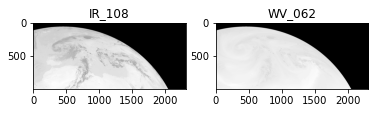

In [7]:
# Визуализируем два канала
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_dict['IR_108'], cmap='gray')
ax[0].title.set_text('IR_108')
ax[1].imshow(img_dict['WV_062'], cmap='gray')
ax[1].title.set_text('WV_062')

In [4]:
# Читаем файлы с долготой, широтой каждого пикселя изображения
n_bytes = 4
shape = (1000, 2312)
precision = 10
dtype = np.int16

with open('data/bb.blk', 'rb') as file:
    lat = np.fromstring(file.read(shape[0] * shape[1] * n_bytes), dtype=dtype)
    lat = np.reshape(lat, shape).astype(np.float64) / precision
    
with open('data/ll.blk', 'rb') as file:
    lon = np.fromstring(file.read(shape[0] * shape[1] * n_bytes), dtype=dtype)
    lon = np.reshape(lon, shape).astype(np.float64) / precision

C:\Users\shand\AppData\Local\Temp\ipykernel_14780\1119858816.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  lat = np.fromstring(file.read(shape[0] * shape[1] * n_bytes), dtype=dtype)
C:\Users\shand\AppData\Local\Temp\ipykernel_14780\1119858816.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  lon = np.fromstring(file.read(shape[0] * shape[1] * n_bytes), dtype=dtype)


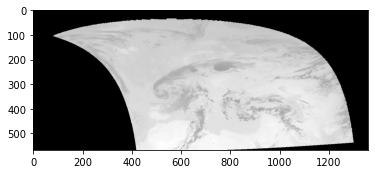

In [10]:
area_id = "Европа и Россия"
description = "Европа и Россия"
proj_id = "EuropeAndRussia"

# Границы области интереса в формате [lon_min, lat_min, lon_max, lat_max]
bounds = [-56.1, 24.3, 79.9, 81.1]

proj_dict = {"proj": "longlat", "ellps": "WGS84", "datum": "WGS84"}
resolution = 0.1  # разрешение в градусах широты / долготы
# расчитаем ширину и высоту изображения

width = int((bounds[2] - bounds[0]) / resolution)
height = int((bounds[3] - bounds[1]) / resolution)

# определяем область
area_def = pyresample.geometry.AreaDefinition(
    area_id, 
    proj_id, 
    description, 
    proj_dict, 
    width, 
    height, 
    bounds
)

# определяем геопривязку
swath_def = pyresample.geometry.SwathDefinition(lons=lon, lats=lat)

# Проектируем
resampled = pyresample.kd_tree.resample_nearest(
    swath_def,
    img_dict['IR_108'],
    area_def,
    radius_of_influence=32000,  # в метрах
    epsilon=0,
    fill_value=0
)

# Заполняем пустоты нулём (чёрным цветом)
resampled[np.isnan(resampled)] = 0

plt.imshow(resampled, cmap='gray')

C:\Users\shand\AppData\Local\Temp\ipykernel_14780\1433444241.py:16: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  ax.background_patch.set_facecolor((0, 0, 0))


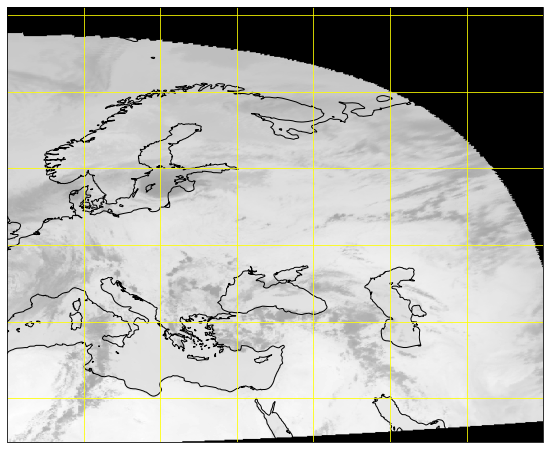

In [20]:
# Географические границы изображения
img_extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
# Географические границы карты
map_extent = [0.0, 70.0, 24.3, 81.1]

# Проекция изображения
img_proj = cartopy.crs.PlateCarree()
# Проекция карты (может отличаться от проекции изображения)
map_proj = cartopy.crs.PlateCarree()

# Создаём график с проекцией карты
fig = plt.figure(frameon=True, figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=map_proj)

# Задний фон делаем чёрным
ax.background_patch.set_facecolor((0, 0, 0))
# Определяем границы карты (графика) в единицах проекции изображения
ax.set_extent(map_extent, crs=img_proj)
# Добавляем береговую линию
ax.coastlines(resolution='50m', color='black')

# Определяем нужные для визуализации меридианы
xticks = [-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80]
# Определяем нужные для визуализации параллели
yticks = [-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80]
# Рисуем меридианы и параллели
ax.gridlines(xlocs=xticks, ylocs=yticks, color='yellow')

# Накладываем изображение на карту
ax.imshow(resampled, transform=img_proj, extent=img_extent, origin='upper', cmap='gray')